In [15]:
import os, glob
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import matplotlib.lines as mlines

import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, gaussian_filter, label, find_objects
from sklearn.decomposition import PCA

from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
import skimage.io as io
from skimage.exposure import adjust_gamma
import imageio
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [8]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


In [97]:
def compute_spatial_recurrence_with_counts(df, window_size=10, radius=5.0):
    """
    Computes the recurrence fraction of new track start locations across consecutive 
    non-overlapping time windows, while also tracking the number of new track points 
    in each window for context.

    Parameters:
    -----------
    df : pd.DataFrame
        Trackpy dataframe with columns ['frame', 'x', 'y', 'particle'].

    window_size : int, default=10
        Number of frames per non-overlapping window.

    radius : float, default=5.0
        Maximum distance (in pixels) to consider two track starts spatially recurrent.

    Returns:
    --------
    pd.DataFrame
        DataFrame with recurrence data including:
        - win1_start, win1_end
        - win2_start, win2_end
        - recurrence_fraction
        - count_win1: number of new tracks in window 1
        - count_win2: number of new tracks in window 2
    """
    import numpy as np
    import pandas as pd
    from scipy.spatial import cKDTree

    new_tracks = df[df['frame'] == df.groupby('particle')['frame'].transform('min')]
    frames = list(range(df['frame'].min(), df['frame'].max() + 1))
    windows = []

    for i in range(0, len(frames) - window_size + 1, window_size):
        win = frames[i:i + window_size]
        coords = new_tracks[new_tracks['frame'].isin(win)][['y', 'x']].values
        windows.append((win, coords))

    records = []
    for (win1, coords1), (win2, coords2) in zip(windows[:-1], windows[1:]):
        count1, count2 = len(coords1), len(coords2)

        if count1 == 0 or count2 == 0:
            frac = np.nan
        else:
            tree = cKDTree(coords1)
            distances, _ = tree.query(coords2, distance_upper_bound=radius)
            n_recurrent = np.sum(distances < radius)
            frac = n_recurrent / count2

        records.append({
            'win1_start': win1[0],
            'win1_end': win1[-1],
            'win2_start': win2[0],
            'win2_end': win2[-1],
            'recurrence_fraction': frac,
            'count_win1': count1,
            'count_win2': count2
        })

    return pd.DataFrame(records)



def load_and_compute_mean_recurrence(paths, radius=27.78, window_size=30, min_count_threshold=3):
    """
    Loads trajectory CSVs from given file paths and computes mean recurrence
    for each using specified radius and window size.

    Parameters:
    -----------
    paths : list of str
        List of folder paths containing 'tp_trajectories_final.csv'.

    radius : float, default=20
        Radius (in pixels) used to determine spatial recurrence.

    window_size : int, default=25
        Number of frames in each non-overlapping time window.

    min_count_threshold : int, default=5
        Minimum number of new tracks in win2 to include recurrence value.

    Returns:
    --------
    pd.DataFrame
        DataFrame with mean recurrence per file, including:
        - 'file_address'
        - 'mean_recurrence'
    """
    results = []

    for path in paths:
        csv_path = os.path.join(path, 'tp_trajectories_final.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            if {'frame', 'x', 'y', 'particle'}.issubset(df.columns):
                rec_df = compute_spatial_recurrence_with_counts(df, window_size, radius)
                filtered = rec_df[rec_df['count_win2'] >= min_count_threshold]
                mean_recurrence = filtered['recurrence_fraction'].mean()
                results.append({'file_address': path, 'mean_recurrence': mean_recurrence})

    return pd.DataFrame(results)


## Combining all the .csv files into three stages: early, middle and late
### Calculating spatial correlation

In [98]:
## DIV2
div2_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min')
div2_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse2_2secPerTP_5min')
div2_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse3_2secPerTP_10min')
div2_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse2_1')
div2_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_A1_timelapse1')
div2_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_A1_timelapse2')
div2_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_06_24_cortical_div2_timelapse1')


## DIV3
div3_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse1')
div3_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse2')
div3_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse3')
div3_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_01_21_div3cortex_timelapse4')
div3_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div3\control_2019_03_24_div3_corticalNeurons_timelapse1_preEfield_5min')


## DIV5
div5_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_07_20_MAX_A1_40x_timelapse2 (2 sec per T)')
div5_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_07_20_MAX_A3_40x_timelapse2 (2 sec per T)')
div5_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse1')
div5_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse3')
div5_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div5\control_2018_08_24_MAX_40x_Cx_CellLight on DIV3 for48h_488_timelapse2')


## DIV7
div7_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_A1_24h on DIV3_488_timelapse2')
div7_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_B1_48h on DIV3_488_timelapse3')
div7_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_08_24_MAX_Cx_C1_24h on DIV6_488_timelapse6')
div7_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2018_10_01_MAX_40x_CX6well_+PDL+LAMglass_Movie2')
div7_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFPonly_DIV7_timelapse')
div7_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C1_glass+PDL_timelapse1')
div7_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse1')
div7_addr8 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_01_21_C2_glass+PDL_timelapse2')
div7_addr9 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFP_RFP 2.5_2.5 DIV7 488_561 timelapse3_C1')
div7_addr10 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_04_22_GFP_RFP 5_5 DIV7 488_561 timelapse1_C1')
div7_addr11 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2019_06_24_cortical_div7_timelapse_2')
div7_addr12 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2021_12_06_div7neurons_dish1_15mm_40x_neuron2_media')
div7_addr13 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div7\control_2021_12_06_div7neurons_dish1_15mm_40x_neuron1_media')


## DIV10
div10_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2019_04_22_NewPdl_GFP RFP_5 5_488_timelapse1')
div10_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron1_media')
div10_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron2_media')
div10_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron3_media')
div10_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron4_media')
div10_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div10\control_div10_glass_2021_12_06_dish2_control_neuron5_media')

## DIV11

div11_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div11\control_2019_02_11_CL+DIV7_Cort_timelapse5')

## DIV12
div12_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div12\control_2018_08_24_MAX_Cx_40x_B1+CLonDIV3_timelapse1')

## DIV14
div14_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div14\control_2019_02_11_Cort_DIV3_top_timelapse1')
div14_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div14\control_2019_02_11_plate1_timelapse1')

## DIV16
div16_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+DIV10_timelapse1')
div16_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV10_timelapse1')
div16_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV10_timelapse2_2')
div16_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse2')
div16_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+DIV6_timelapse2_2')
div16_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse1')

## DIV17
div17_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse2')
div17_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse4')
div17_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate2_timelapse1')
div17_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse3')

## DIV21
div21_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_02_11_Coth_+CLDIV14_timelapse')
div21_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_04_22_Cort_DIV21_+CLDIV17_NewPDL_timelapse2a')
div21_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div21\control_2019_04_22_Cort_DIV21_+CLDIV17_NewPDL_timelapse2b')


## DIV23
div23_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1')
div23_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div23\control_div23_glass_2019_04_22_CortDIV23_+ClDIV17+en_timelapse1b')


## Combining all the .csv files into three stages: early, middle and late
### Calculating the spatial correlation metrics

In [99]:
# Define the paths for each DIV group
div2_paths = [div2_addr1, div2_addr2, div2_addr3, div2_addr4, div2_addr5, div2_addr6, div2_addr7]
div3_paths = [div3_addr1, div3_addr2, div3_addr3, div3_addr4, div3_addr5]
div5_paths = [div5_addr1, div5_addr2, div5_addr3, div5_addr4, div5_addr5]

div7_paths = [div7_addr1, div7_addr2, div7_addr3, div7_addr4, div7_addr5, div7_addr6, div7_addr7, div7_addr8, div7_addr9, div7_addr10, div7_addr11, div7_addr12, div7_addr13]
div10_paths = [div10_addr1, div10_addr2, div10_addr3, div10_addr4, div10_addr5, div10_addr6]
div11_paths = [div11_addr1]
div12_paths = [div12_addr1]

div14_paths = [div14_addr1, div14_addr2]
div16_paths = [div16_addr1, div16_addr2, div16_addr3, div16_addr4, div16_addr5, div16_addr6]
div17_paths = [div17_addr1, div17_addr2, div17_addr3, div17_addr4]
div21_paths = [div21_addr1, div21_addr2, div21_addr3]
div23_paths = [div23_addr1, div23_addr2]


# Load each stage and compute saptial correlation
early_stage = load_and_compute_mean_recurrence(div2_paths + div3_paths + div5_paths)
middle_stage = load_and_compute_mean_recurrence(div7_paths + div10_paths + div11_paths + div12_paths)
late_stage = load_and_compute_mean_recurrence(div14_paths + div16_paths + div17_paths + div21_paths + div23_paths)


# Concatenate along a new axis with MultiIndex
early_stage_merged = pd.concat({'early_stage': early_stage}, axis=0)
middle_stage_merged = pd.concat({'middle_stage': middle_stage}, axis=0)
late_stage_merged = pd.concat({'late_stage': late_stage}, axis=0)

# Define output folder
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames')

# Save the merged DataFrames as CSV files with indexing
early_stage_merged.to_csv(data_folder + '\\early_stage_spatial_correlation.csv', index=True)
middle_stage_merged.to_csv(data_folder + '\\middle_stage_spatial_correlation.csv', index=True)
late_stage_merged.to_csv(data_folder + '\\late_stage_spatial_correlation.csv', index=True)


print("Spatial correlation saved as 'early_stage_spatial_correlation.csv', 'middle_stage_spatial_correlation.csv', and 'late_stage_spatial_correlation.csv'")


Spatial correlation saved as 'early_stage_spatial_correlation.csv', 'middle_stage_spatial_correlation.csv', and 'late_stage_spatial_correlation.csv'


## All nanoridged movies

In [100]:
# Define the paths for each DIV group

## DIV2
div2_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1')
div2_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse4a')
div2_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse2')
div2_addr4 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse3')
div2_addr5 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse5')
div2_addr6 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_01_21_div2cortex_B1_timelapse6')
div2_addr7 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse7')

## DIV3
div3_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div3\ridges_2021_04_16_well2_timelapse1_PFS')

## DIV4
div4_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div4\ridges_2019_02_11_C2_ridges_timelapse2')


## DIV7
div7_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B1_ridges_timelapse1')
div7_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B1_ridges_timelapse2')
div7_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div7\ridges_2019_01_21_B2_ridges_timelapse4')


## DIV8
div8_addr1 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse1')
div8_addr2 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse3')
div8_addr3 = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div8\ridges_2019_02_11_C2_ridges_timelapse4')



## Combining all the .csv files into two stages: early and middle
### Calculating the spatial correlation metrics

In [101]:
# Load each stage by combining the respective DIV groups

# Early stage: DIV2, 3 and 4
div2_paths = [div2_addr1, div2_addr2, div2_addr3, div2_addr4, div2_addr5, div2_addr6, div2_addr7]
div3_paths = [div3_addr1]
div4_paths = [div4_addr1]

# Middle stage: Combine DIV7 and DIV8
div7_paths = [div7_addr1, div7_addr2, div7_addr3]
div8_paths = [div8_addr1, div8_addr2, div8_addr3]

# Load each stage and compute turning metrics
early_stage = load_and_compute_mean_recurrence(div2_paths + div3_paths + div4_paths)
middle_stage = load_and_compute_mean_recurrence(div7_paths + div8_paths)


# Concatenate along a new axis with MultiIndex
early_stage_merged = pd.concat({'early_stage': early_stage}, axis=0)
middle_stage_merged = pd.concat({'middle_stage': middle_stage}, axis=0)


# Define output folder
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames')

# Save the merged DataFrames as CSV files with indexing
early_stage_merged.to_csv(data_folder + '\\early_stage_spatial_correlation.csv', index=True)
middle_stage_merged.to_csv(data_folder + '\\middle_stage_spatial_correlation.csv', index=True)


print("Turning metrics saved as 'early_stage_spatial_correlation_spatial_correlation.csv', 'middle_stage_spatial_correlation.csv'")
 

Turning metrics saved as 'early_stage_spatial_correlation_spatial_correlation.csv', 'middle_stage_spatial_correlation.csv'


In [104]:
def plot_combined_mean_recurrence_boxplots(stage_files, stage_labels, group_labels):
    """
    Plots combined boxplots for precomputed mean recurrence values across multiple stages and surfaces.

    Parameters:
        stage_files (list of list of str): List of CSV file paths for each stage.
        stage_labels (list of str): Labels for the x-axis boxplots (e.g., stages).
        group_labels (list of str): Legend labels for surfaces (e.g., "Flat", "Ridges").
    """
    recurrence_values = []
    group_colors = ['#1E88E5', '#F4511E', '#8E24AA', '#1E88E5', '#F4511E']  # consistent colors

    for file_group in stage_files:
        stage_vals = []
        for file_path in file_group:
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if 'mean_recurrence' in df.columns:
                    vals = df['mean_recurrence'].dropna().values
                    stage_vals.extend(vals)
        recurrence_values.append(np.array(stage_vals))

    # Plot boxplot
    plt.figure(figsize=(8, 8))
    box = plt.boxplot(recurrence_values, patch_artist=False, medianprops=dict(color="black", linewidth=2),
                      widths=0.4, vert=True, positions=np.arange(1, len(stage_labels) + 1))

    plt.ylim([-0.05, 0.85])

    # Scatter markers for flat and ridge
    flat_markers = ["^", "^", "^"]
    ridged_markers = ["d", "d"]

    for i, recs in enumerate(recurrence_values):
        marker = flat_markers[i] if i < 3 else ridged_markers[i - 3]
        plt.scatter([i + 1] * len(recs), recs, s=80, color=group_colors[i], alpha=0.7,
                    marker=marker, edgecolor='black', linewidth=1)

    plt.xticks(np.arange(1, len(stage_labels) + 1), stage_labels, fontsize=24)
    plt.xlabel("Stage", fontsize=32)
    plt.ylabel("Mean recurrence", fontsize=32)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Legend
    flat_legend = mlines.Line2D([], [], color='black', marker='^', markersize=10, label='Flat')
    ridged_legend = mlines.Line2D([], [], color='black', marker='d', markersize=10, label='Ridge')
    plt.legend(handles=[flat_legend, ridged_legend], loc='upper right', fontsize=22)

    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Combined Plots_glass_vs_ridge\\flat_vs_ridge_mean_recurrence.svg',
                format='svg', bbox_inches='tight')
    plt.show()


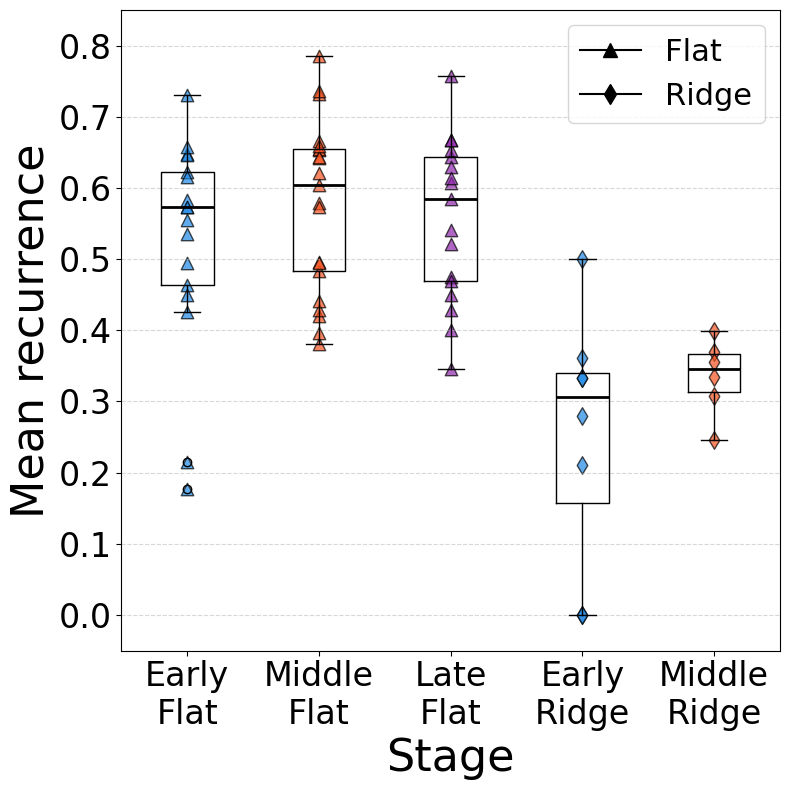

In [105]:
stage_files = [
    # Flat
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_spatial_correlation.csv"],
    # Ridges
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_spatial_correlation.csv"]
]

stage_labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]
group_labels = ["Flat", "Ridge"]

plot_combined_mean_recurrence_boxplots(stage_files, stage_labels, group_labels)


In [106]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def test_mean_recurrence_from_csvs(stage_files, stage_labels, output_path="mean_recurrence_stats.csv"):
    """
    Loads mean recurrence values from CSVs, tests for normality, and performs appropriate statistical tests:
    - Shapiro–Wilk for normality
    - ANOVA + Tukey HSD for Flat intra-group comparison (if normal and significant)
    - Kruskal–Wallis as fallback for non-normal data
    - T-tests or Mann–Whitney U for Flat vs Ridge and Ridge intra-group comparisons

    Saves all results to a CSV file.

    Parameters:
    -----------
    stage_files : list of list of str
        Each sublist contains paths to CSV files representing one stage.

    stage_labels : list of str
        Labels for each stage, used in output and plotting.

    output_path : str
        Path where the CSV summary of statistical results will be saved.
    """

    results = []
    recurrence_values = []

    # ----------------------------------
    # Load recurrence values from CSVs
    # ----------------------------------
    for group in stage_files:
        stage_vals = []
        for csv_file in group:
            df = pd.read_csv(csv_file)
            if 'mean_recurrence' not in df.columns:
                raise ValueError(f"{csv_file} must contain a 'mean_recurrence' column.")
            stage_vals.extend(df['mean_recurrence'].dropna().values)
        recurrence_values.append(np.array(stage_vals))

    # ----------------------------------
    # Shapiro–Wilk Normality Test
    # ----------------------------------
    normality_results = []
    for i, vals in enumerate(recurrence_values):
        stat, p = shapiro(vals)
        normality_results.append(p)
        normality_label = 'Normal' if p >= 0.05 else 'Non-normal'
        print(f"Shapiro–Wilk for {stage_labels[i]}: p = {p:.3g} → {normality_label}")
        results.append({
            'Comparison': f"Shapiro–Wilk: {stage_labels[i]}",
            'Test': 'Shapiro–Wilk',
            'Stat': stat,
            'p-value': p,
            'Significance': normality_label
        })

    any_non_normal = any(p < 0.05 for p in normality_results)
    print(f"\nUsing {'non-parametric' if any_non_normal else 'parametric'} tests.\n")

    # ----------------------------------
    # Flat vs Ridge comparisons (Early & Middle)
    # ----------------------------------
    for i in range(2):  # Compare Early and Middle only
        flat = recurrence_values[i]
        ridge = recurrence_values[i + 3]
        stage = stage_labels[i].split('\n')[0]
        if any_non_normal:
            stat, p = mannwhitneyu(flat, ridge, alternative='two-sided')
            test_name = "Mann–Whitney U"
        else:
            stat, p = ttest_ind(flat, ridge, equal_var=False)
            test_name = "T-test"
        print(f"{test_name} for {stage} stage (Flat vs Ridge): stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': f"{stage} Flat vs Ridge",
            'Test': test_name,
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })

    # ----------------------------------
    # FLAT: ANOVA + Tukey or Kruskal–Wallis
    # ----------------------------------
    flat_vals = recurrence_values[:3]
    flat_labels = stage_labels[:3]
    flat_concat = np.concatenate(flat_vals)
    flat_stage_names = np.concatenate([[label] * len(vals) for label, vals in zip(flat_labels, flat_vals)])

    if any_non_normal:
        stat, p = kruskal(*flat_vals)
        test_name = "Kruskal–Wallis"
        print(f"{test_name} across Flat stages: stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': 'Flat: Early vs Middle vs Late',
            'Test': test_name,
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })
    else:
        stat, p = f_oneway(*flat_vals)
        print(f"ANOVA across Flat stages: stat = {stat:.3f}, p = {p:.3g}")
        results.append({
            'Comparison': 'Flat: Early vs Middle vs Late',
            'Test': 'ANOVA',
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })

        # Run Tukey HSD if significant
        if p < 0.05:
            print("→ Running Tukey’s HSD post-hoc test for Flat:")
            tukey_result = pairwise_tukeyhsd(flat_concat, flat_stage_names, alpha=0.05)
            print(tukey_result)
            tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
            tukey_df.insert(0, 'Comparison', 'Tukey HSD (Flat)')
            tukey_df.to_csv(output_path.replace('.csv', '_tukey.csv'), index=False)

    # ----------------------------------
    # RIDGES: Early vs Middle
    # ----------------------------------
    ridge_early = recurrence_values[3]
    ridge_middle = recurrence_values[4]

    if any_non_normal:
        stat, p = mannwhitneyu(ridge_early, ridge_middle, alternative='two-sided')
        test_name = "Mann–Whitney U"
    else:
        stat, p = ttest_ind(ridge_early, ridge_middle, equal_var=False)
        test_name = "T-test"

    print(f"{test_name} for Early vs Middle (Ridges): stat = {stat:.3f}, p = {p:.3g}")
    results.append({
        'Comparison': 'Ridges: Early vs Middle',
        'Test': test_name,
        'Stat': stat,
        'p-value': p,
        'Significance': 'Yes' if p < 0.05 else 'No'
    })

    # ----------------------------------
    # Save all summary results
    # ----------------------------------
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n✅ Results saved to: {output_path}")


In [107]:
stage_files = [
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\early_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\middle_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames\late_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\early_stage_spatial_correlation.csv"],
    [r"E:\Spandan\2D_Neurons_Paper\Ridges\minimum_8_frames\middle_stage_spatial_correlation.csv"]
]

stage_labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]

test_mean_recurrence_from_csvs(stage_files, stage_labels,
    output_path=r"E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge\mean_recurrence_stats.csv")


Shapiro–Wilk for Early
Flat: p = 0.0293 → Non-normal
Shapiro–Wilk for Middle
Flat: p = 0.258 → Normal
Shapiro–Wilk for Late
Flat: p = 0.711 → Normal
Shapiro–Wilk for Early
Ridge: p = 0.297 → Normal
Shapiro–Wilk for Middle
Ridge: p = 0.82 → Normal

Using non-parametric tests.

Mann–Whitney U for Early stage (Flat vs Ridge): stat = 121.000, p = 0.00222
Mann–Whitney U for Middle stage (Flat vs Ridge): stat = 124.000, p = 2.7e-05
Kruskal–Wallis across Flat stages: stat = 0.713, p = 0.7
Mann–Whitney U for Early vs Middle (Ridges): stat = 15.000, p = 0.271

✅ Results saved to: E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge\mean_recurrence_stats.csv
